<a href="https://colab.research.google.com/github/Xojiakbar/BARBOS/blob/master/oneSVM_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import dataset
from sklearn.datasets import make_classification

#import libraries
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
#Data preparation, making imbalanced dataset
X, y = make_classification(n_samples=100000, n_features=2, n_informative=2,n_redundant=0, n_repeated=0, n_classes = 2, n_clusters_per_class = 1, weights = [0.995, 0.005], class_sep = 0.5, random_state = 0)

#Convert from np to pd
df = pd.DataFrame({'feature1': X[:,0], 'feature2': X[:,1], 'target':y})

# Checking the target distribution
df['target'].value_counts(normalize = True)

0    0.9897
1    0.0103
Name: target, dtype: float64

In [3]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

#Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 80000
The number of records in the test dataset is 20000
The training dataset has 79183 records for the majority class and 817 records for the minority class.


In [4]:
#Training One class SVM
one_class_svm = OneClassSVM(nu = 0.01, kernel = 'rbf', gamma = 'auto').fit(X_train)

In [5]:
#Predict anomalies
prediction = one_class_svm.predict(X_test)

#Change the anomalies' values to make it consistent with the true values
prediction = [1 if i==-1 else 0 for i in prediction]

# Check the model performance
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19787
           1       0.06      0.06      0.06       213

    accuracy                           0.98     20000
   macro avg       0.53      0.53      0.53     20000
weighted avg       0.98      0.98      0.98     20000



In [9]:
#Customize the predictions using scores
#Get the scores for the testing dataset
score = one_class_svm.score_samples(X_test)

#Check the score for 8% of outliers
score_threshold = np.percentile(score, 8)
print(f'The customized score threshold for 2% of outliers is {score_threshold:.2f}')

#Check the model performance at 2% threshold
customized_prediction = [1 if i< score_threshold else 0 for i in score]

# Check the prediction performance
print(classification_report(y_test, customized_prediction))

The customized score threshold for 2% of outliers is 190.18
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     19787
           1       0.03      0.20      0.05       213

    accuracy                           0.91     20000
   macro avg       0.51      0.56      0.50     20000
weighted avg       0.98      0.91      0.95     20000



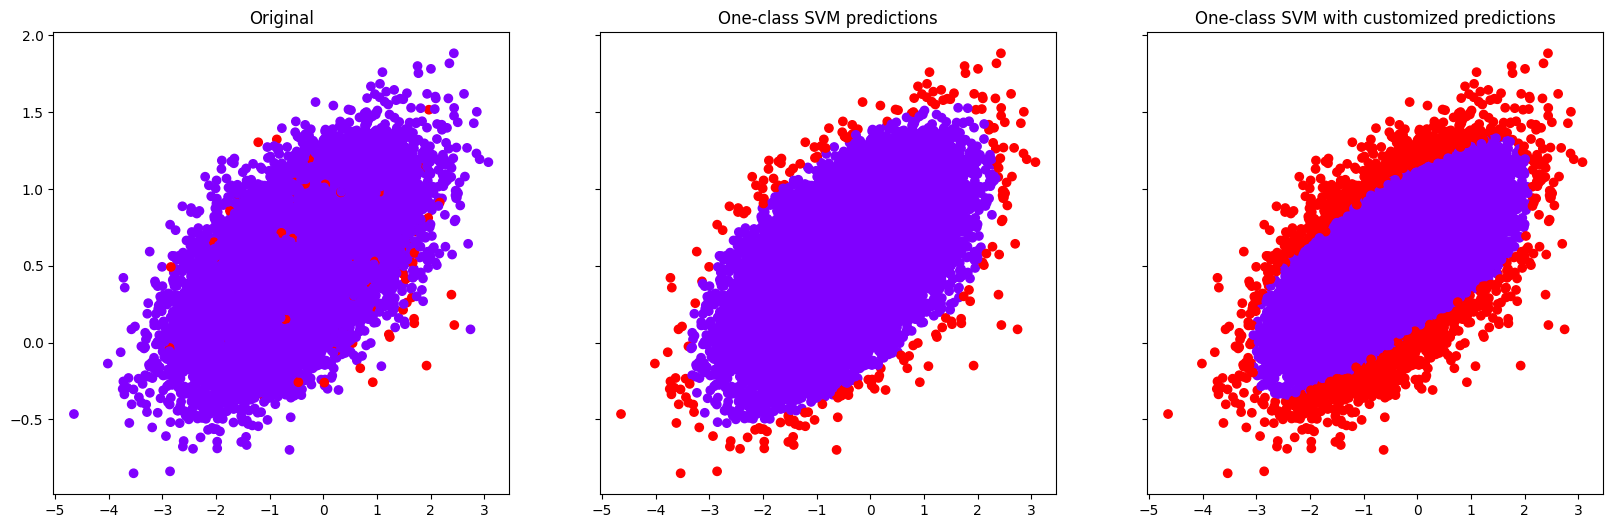

In [10]:
#Visualization
#Testing dataset and prediction in the same dataframe
df_test = pd.DataFrame(X_test, columns=['feature1', 'feature2'])
df_test['y_test'] = y_test
df_test['one_class_svm_prediction'] = prediction 
df_test['one_class_svm_prediction_cust'] = customized_prediction

#Visualize the actual and predicted anomalies
fig, (ax0, ax1, ax2) = plt.subplots(1,3, sharey = True, figsize=(20,6))

#Ground truth
ax0.set_title('Original')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')

#One-class SVM predictions
ax1.set_title('One-class SVM predictions')
ax1.scatter(df_test['feature1'], df_test['feature2'], c = df_test['one_class_svm_prediction'], cmap='rainbow')

#One-class SVM customized predictions
ax2.set_title('One-class SVM with customized predictions')
ax2.scatter(df_test['feature1'], df_test['feature2'], c = df_test['one_class_svm_prediction_cust'], cmap='rainbow')